# Argument Quality Prediction

El objetivo de este proyecto se basa en crear modelos de machine para clasificar los elementos argumentativos en los textos escritos por estudiantes como "efectivos", "adecuados" o "ineficaces". Esta clasificación automatizada tiene como objetivo proporcionar una mejor retroalimentación a los estudiantes, para así ellos puedan mejorar sus habilidades de escritura.


In [106]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import joblib

In [107]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [108]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Data Loading and Initial Inspection

In [109]:
train_df = pd.read_csv('data/train_preprocessed.csv')
# Display the first few rows
train_df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text_length,text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,317,hi im isaac im going writing face mars natural...
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,210,perspective think face natural landform dont t...
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,105,think face natural landform life mars descover...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,362,life mars would know reason think natural land...
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,101,people thought face formed alieans thought lif...


## 2. Enhanced Preprocessing

In [113]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [114]:
# Define a custom tokenizer using NLTK's word_tokenize and additional preprocessing
def custom_tokenizer(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [115]:
# Apply the tokenizer to the text data
train_df['tokens'] = train_df['text'].apply(custom_tokenizer)

# Display tokenized text
train_df[['text', 'tokens']].head()

,text,tokens
0,hi im isaac im going writing face mars natural...,"[hi, im, isaac, im, going, writing, face, mars..."
1,perspective think face natural landform dont t...,"[perspective, think, face, natural, landform, ..."
2,think face natural landform life mars descover...,"[think, face, natural, landform, life, mars, d..."
3,life mars would know reason think natural land...,"[life, mars, would, know, reason, think, natur..."
4,people thought face formed alieans thought lif...,"[people, thought, face, formed, alieans, thoug..."


## 3. Feature Engineering

In [116]:
# Initialize the TF-IDF Vectorizer with the custom tokenizer
tfidf = TfidfVectorizer(
    max_features=10000,  # Number of features
    ngram_range=(1,3),   # Including up to trigrams
    tokenizer=custom_tokenizer,
    token_pattern=None    # To use the custom tokenizer
)


In [117]:
# Fit and transform the text data
X_text = tfidf.fit_transform(train_df['text'])

In [118]:
# from sklearn.decomposition import TruncatedSVD
# # Reduce dimensionality with Truncated SVD
# svd = TruncatedSVD(n_components=300, random_state=42)
# X_text_reduced = svd.fit_transform(X_text)

In [119]:
# Scale the 'text_length' feature
scaler = StandardScaler()
X_length = scaler.fit_transform(train_df[['text_length']])

In [120]:
# One-Hot Encode the 'discourse_type' feature
ohe = OneHotEncoder(drop='first', sparse_output=True)
X_discourse = ohe.fit_transform(train_df[['discourse_type']])

In [121]:
# Concatenate all features
import scipy.sparse as sp
X = sp.hstack([X_text, X_length, X_discourse]).tocsr()

In [122]:
# Encode the labels
le = LabelEncoder()
y = le.fit_transform(train_df['discourse_effectiveness'])

## 4. Train-Test Split

In [123]:
# Split the data into training and validation sets **before** applying SMOTE
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')

Training samples: 29405
Validation samples: 7352


## 5. Handling Class Imbalance with Under-sampling and SMOTE

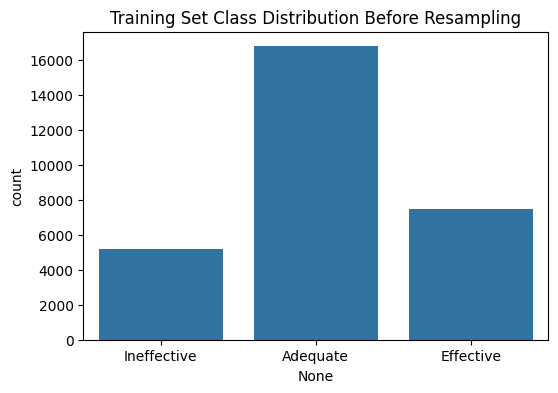

In [124]:
# Visualize class distribution before any resampling
plt.figure(figsize=(6,4))
sns.countplot(x=pd.Series(y_train).map(lambda x: le.inverse_transform([x])[0]))
plt.title('Training Set Class Distribution Before Resampling')
plt.show()

In [125]:
# Define the target number of samples for the majority class (Adequate)
# For example, set it to the number of samples in the minority class (Ineffective: 6000)
# Adjust this number based on your specific needs
target_adequate = y_train[y_train == le.transform(['Adequate'])[0]].shape[0]
print(f'\nOriginal Adequate class count: {target_adequate}')


Original Adequate class count: 16778


In [126]:
# To prevent over-sampling Adequate, we'll under-sample it to a lower number
# Let's set Adequate to 8000 to match Effective
desired_adequate = 8000

In [127]:
# Define sampling_strategy for under-sampling
# Keep 'Ineffective' and 'Effective' as is, and under-sample 'Adequate' to desired_adequate
from collections import Counter

def get_sampling_strategy(y, desired_adequate):
    counter = Counter(y)
    majority_class = le.transform(['Adequate'])[0]
    sampling_strategy = {cls: count for cls, count in counter.items()}
    sampling_strategy[majority_class] = desired_adequate
    return sampling_strategy

sampling_strategy = get_sampling_strategy(y_train, desired_adequate)
print("\nSampling strategy for under-sampling:")
for cls, count in sampling_strategy.items():
    print(f"{le.inverse_transform([cls])[0]}: {count}")


Sampling strategy for under-sampling:
Ineffective: 5166
Adequate: 8000
Effective: 7461


In [128]:
# Apply RandomUnderSampler to reduce Adequate class
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [129]:
print("\nTraining set class distribution after under-sampling:")
print(Counter(y_train_under))


Training set class distribution after under-sampling:
Counter({0: 8000, 1: 7461, 2: 5166})


In [130]:
# Apply SMOTE to oversample minority classes (Ineffective and Effective)
# Define sampling_strategy for SMOTE: make all classes have the same number of samples as the majority class after under-sampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_under, y_train_under)

In [131]:
print("\nTraining set class distribution after SMOTE:")
print(Counter(y_train_resampled))


Training set class distribution after SMOTE:
Counter({0: 8000, 1: 8000, 2: 8000})


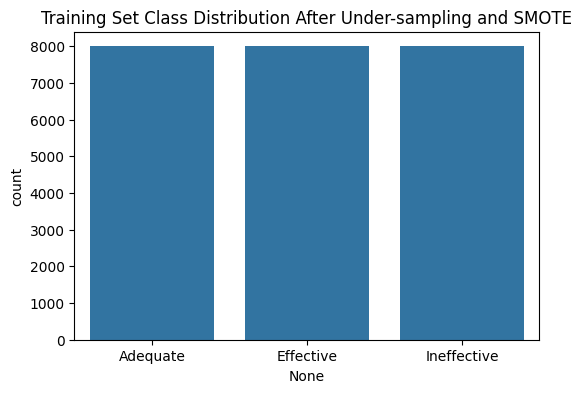

In [132]:
# Visualize the final training set class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=pd.Series(y_train_resampled).map(lambda x: le.inverse_transform([x])[0]))
plt.title('Training Set Class Distribution After Under-sampling and SMOTE')
plt.show()

## 6. PyTorch Dataset and DataLoader

In [133]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.toarray()).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [134]:
# Create Dataset objects
train_dataset = TextDataset(X_train_resampled, y_train_resampled)
val_dataset = TextDataset(X_val, y_val)

In [135]:
# Create DataLoader objects
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 7. Define the PyTorch Model

In [136]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Focal Loss for multi-class classification
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        logpt = -self.ce(inputs, targets)
        pt = torch.exp(logpt)
        focal_loss = -((1 - pt) ** self.gamma) * logpt
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [137]:
class NeuralNetPyTorch(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetPyTorch, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [138]:
# Initialize the model
input_size = X_train.shape[1]
num_classes = len(le.classes_)
model = NeuralNetPyTorch(input_size, num_classes)

In [139]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f'Using device: {device}')

Using device: cpu


## 8. Define Loss Function and Optimizer

In [140]:
# Option 1: Use Focal Loss
criterion = FocalLoss(gamma=2)

In [141]:
# Option 2: Use CrossEntropyLoss with class weights
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

In [142]:
# Use Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=3,
                                                 verbose=True)


## 9. Training the Model

In [143]:
# Define the number of epochs and early stopping parameters
epochs = 50
patience = 7
best_val_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [144]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')
    print(f'Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

    # Step the scheduler
    scheduler.step(val_epoch_loss)

    # Check for early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered!')
            break

Epoch 1/50
Train Loss: 0.3629 | Train Acc: 0.5899
Val Loss: 0.3306 | Val Acc: 0.5626
Epoch 2/50
Train Loss: 0.2160 | Train Acc: 0.7467
Val Loss: 0.3609 | Val Acc: 0.5506
Epoch 3/50
Train Loss: 0.1402 | Train Acc: 0.8261
Val Loss: 0.4517 | Val Acc: 0.5379
Epoch 4/50
Train Loss: 0.0946 | Train Acc: 0.8795
Val Loss: 0.5573 | Val Acc: 0.5426
Epoch 5/50
Train Loss: 0.0724 | Train Acc: 0.9097
Val Loss: 0.6448 | Val Acc: 0.5611
Epoch 6/50
Train Loss: 0.0432 | Train Acc: 0.9480
Val Loss: 0.7869 | Val Acc: 0.5496
Epoch 7/50
Train Loss: 0.0298 | Train Acc: 0.9640
Val Loss: 0.8328 | Val Acc: 0.5635
Epoch 8/50
Train Loss: 0.0242 | Train Acc: 0.9716
Val Loss: 0.9338 | Val Acc: 0.5533
Early stopping triggered!


## 10. Load the Best Model

In [153]:
# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

## 11. Evaluation

In [154]:
# Define evaluation function
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

In [155]:
# Get predictions on the validation set
y_pred, y_true = evaluate_model(model, val_loader)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Weighted F1-Score: {f1:.4f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=le.classes_))

Validation Accuracy: 0.5626
Validation Weighted F1-Score: 0.5697
Classification Report:
              precision    recall  f1-score   support

    Adequate       0.72      0.48      0.58      4195
   Effective       0.59      0.71      0.64      1865
 Ineffective       0.35      0.62      0.45      1292

    accuracy                           0.56      7352
   macro avg       0.55      0.60      0.55      7352
weighted avg       0.62      0.56      0.57      7352



## 12. Confusion Matrix

In [157]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

array([[2014,  826, 1355],
       [ 403, 1319,  143],
       [ 385,  104,  803]], dtype=int64)

In [158]:
def confunsion_to_pd(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
    return cm_df

confusion_matrix_df = confunsion_to_pd(y_true, y_pred)
confusion_matrix_df

,Adequate,Effective,Ineffective
Adequate,2014,826,1355
Effective,403,1319,143
Ineffective,385,104,803


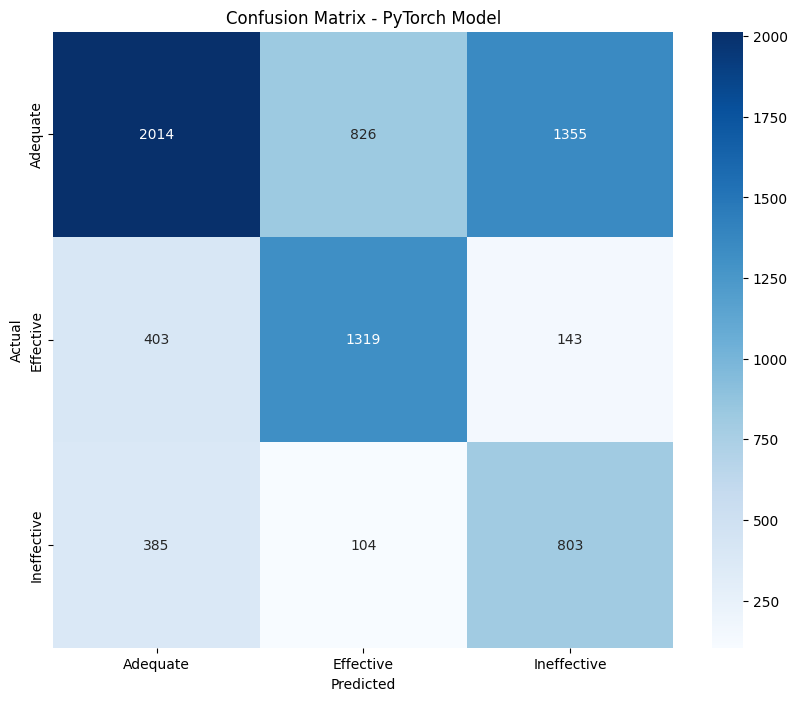

In [149]:
plot_confusion(y_true, y_pred, 'Confusion Matrix - PyTorch Model')

## 13. Training Curves

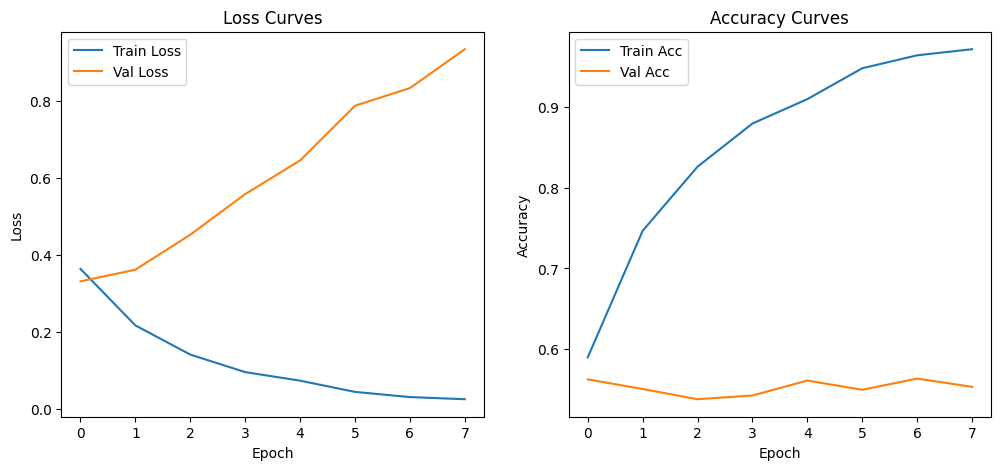

In [150]:
# Plot training and validation loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.show()

## 14. Saving the Model and Vectorizer

In [151]:
# Save the trained model
torch.save(model.state_dict(), 'pytorch_text_model_enhanced.pth')

In [152]:
# Save the TF-IDF vectorizer and SVD
import joblib
joblib.dump(tfidf, 'tfidf_vectorizer_enhanced.joblib')
joblib.dump(svd, 'truncated_svd_enhanced.joblib')

# Save the label encoder
joblib.dump(le, 'label_encoder.joblib')

['label_encoder.joblib']